In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
import numpy as np
from model import unet,unet_backbone

In [2]:
torch.manual_seed(17)

In [3]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = read_voc_images(voc_dir)

In [4]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [5]:
batch_size = 64
train_iter = DataLoader(voc_train, batch_size, shuffle=True,drop_last=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [8]:
model = nn.Sequential(*list(pretrained_net.children())[:-2])

In [9]:
# test model output
X = torch.rand(size=(1, 3, 320, 480))
model(X).shape

torch.Size([1, 512, 10, 15])

In [10]:
num_classes = 21
model.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
model.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [12]:
# bilinear weight initialization
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    # for i in range(in_channels):
    #     for j in range(out_channels):
    #         weight[i,j,:,:] = filt
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

In [13]:
W = bilinear_kernel(num_classes, num_classes, 64)
model.transpose_conv.weight.data.copy_(W);

In [14]:
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:

def myloss(inputs,targets):
    return functional.cross_entropy(inputs,targets,reduction='none').mean(1).mean(1)


In [16]:
lr = 0.001
# loss function
loss_fn = myloss
# optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,weight_decay=1e-3)

In [17]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # train(train_dataloader, device, model, loss_fn, optimizer)
    # test(val_dataloader, device, model, loss_fn)
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 218.899963  [    0/ 1114]
Test Error: 
 Accuracy: 79.10%, Avg loss: 53.693165 

Epoch 2
-------------------------------
loss: 43.327698  [    0/ 1114]
Test Error: 
 Accuracy: 81.07%, Avg loss: 44.371683 

Epoch 3
-------------------------------
loss: 42.146294  [    0/ 1114]
Test Error: 
 Accuracy: 84.22%, Avg loss: 34.173298 

Epoch 4
-------------------------------
loss: 32.336842  [    0/ 1114]
Test Error: 
 Accuracy: 84.53%, Avg loss: 32.791942 

Epoch 5
-------------------------------
loss: 30.412493  [    0/ 1114]
Test Error: 
 Accuracy: 84.80%, Avg loss: 31.315332 

Done!


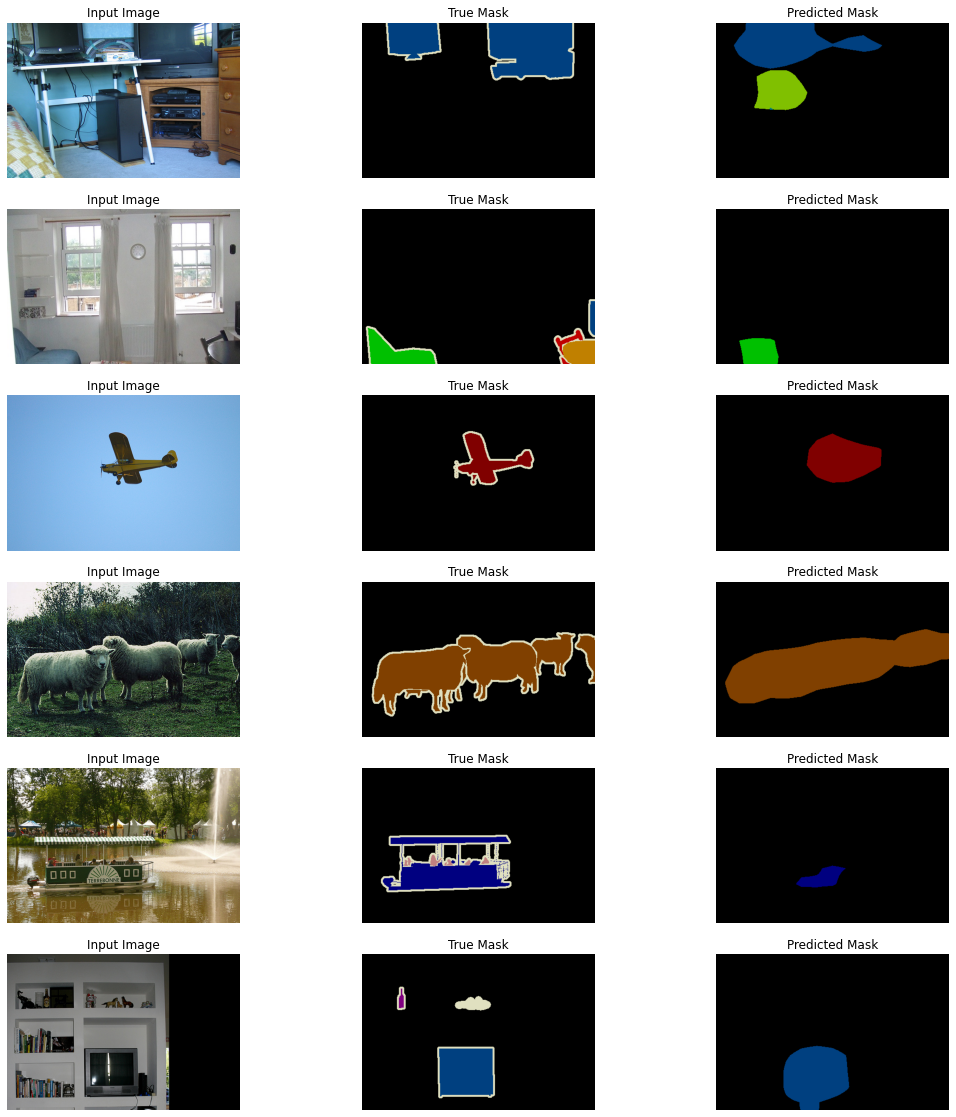

In [20]:
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 6
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [21]:
torch.save(model,'FCN-ResNet18-5epochs.pt')

In [7]:
model = torch.load('FCN-ResNet18-5epochs.pt',map_location=device)

In [8]:
# mean iou
model.eval()
# iou = 0
mean_iou = []
with torch.no_grad():
    for X,y in test_iter:
        X,y = X.to(device),y.to(device)
        pred = model(X)
        pred = torch.argmax(pred,1)
        iou = utils.iou(pred,y,21,ignore_background=True)
        iou = np.mean(iou)
        mean_iou.append(iou)
        print(f'this mean iou is :{iou}')
print(f'mean iou for all is: {np.mean(mean_iou)}')

this mean iou is :0.3378156104258129
this mean iou is :0.3079527032434581
this mean iou is :0.3859563364336888
this mean iou is :0.3782811165559319
this mean iou is :0.36952008460284397
this mean iou is :0.39785676109593077
this mean iou is :0.4014580760683332
this mean iou is :0.36769043750668495
this mean iou is :0.3364621231421119
this mean iou is :0.3104558867731401
this mean iou is :0.3341918092229858
this mean iou is :0.39805882750178334
this mean iou is :0.3529045651897003
this mean iou is :0.3577783364039866
this mean iou is :0.36323580018948143
this mean iou is :0.3582442002939787
this mean iou is :0.34391567263982425
mean iou for all is: 0.3589281380758634
